__Justice is a difficult concept to grasp, let to alone to measure__. Since the XVIIIth century, justice has indeed it been understood to be an inherent right to man, however it's somewhat paradoxical that it requires the swift hand of the law as a deterrent to mantain it. This statement naturally begs the question of who is to make these law enforcement agencies accountable. Through this notebook, we expand upon these questions by relying on [The Police Data Initiative](https://www.policedatainitiative.org/) which promotes the use of open data to encourage joint problem solving, innovation, enhanced understanding, and accountability between communities and the law enforcement agencies that serve them.

Specifically, we focus our attention on the city of Boston (To be Expaned to other US cities) in order to study the whether there is any racial bias within the Standard Operating Procedures of the Boston Police Department. For that matter, we rely on the following datasets:
- [Boston Census Information: Dept_11-00091](https://www.kaggle.com/center-for-policing-equity/data-science-for-good): ACS Census Data for the census blocks within Boston along with the geostatistical and demographic information
- [Boston Police Stops between 2011-2015](https://data.boston.gov/dataset/boston-police-department-fio/resource/c696738d-2625-4337-8c50-123c2a85fbad): Encompassing a wide range of interactions between the Boston Police Department (BPD) and private individuals in the 2011-2015 periods
- [Boston Streets Catalog](https://bostonopendata-boston.opendata.arcgis.com/datasets/cfd1740c2e4b49389f47a9ce2dd236cc_8.geojson): Catalog map of all streets located within Boston

All files needed to run the notebook will be stored [here](https://mega.nz/#!vbJ1FKoK)

# Imports

In [1]:
import numpy as np
import geopandas as gpd
from geopandas.tools import sjoin
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
import os
import matplotlib
import geoplot
import re
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'svg' 
sns.set_style("white")
plt.style.use('bmh')

# Census Data

## File Pretreatment

Here we'll run through the raw census data in order to obtain a consistent data structure easy to work with. We are now going to look for demographic variables that might be later related to the use of police force. Among the ones that first come to mind and that we'll work with are data related to income, employment, education and population composition.

In [3]:
# Rename Columns in Appropriate Format
def treat_census_files(df_census,vars_of_inter,rename_cols,geo_field="GEO.id2"):
    df_census = df_census[vars_of_inter]
    for col in vars_of_inter:
        if col!=geo_field:
            df_census[col] = [float(x) if str(x).replace('.','').isnumeric() else np.nan for x in df_census[col].tolist()]
    rename_dic = {i:j for i,j in zip(vars_of_inter,rename_cols)}
    return df_census.rename(columns=rename_dic,)

In [4]:
# Census Data
data_folder = "../data/Dept_11-00091/11-00091_ACS_data/"

## Income Data
data_income = pd.read_csv(data_folder+"11-00091_ACS_income/ACS_15_5YR_S1903_with_ann.csv").iloc[1:].reset_index(drop=True)
income_vars = ["GEO.id2",
               "HC02_EST_VC02","HC02_MOE_VC02",# overall income (median, std)
               "HC02_EST_VC13","HC02_MOE_VC13",# white income (median, std)
               "HC02_EST_VC05","HC02_MOE_VC05",# black income (median, std)
               "HC02_EST_VC06","HC02_MOE_VC06",# indian income (median, std)
               "HC02_EST_VC07","HC02_MOE_VC07",# asian income (median, std)
               "HC02_EST_VC08","HC02_MOE_VC08",# hawaiian income (median, std)
               "HC02_EST_VC12","HC02_MOE_VC12",# latino income (median, std)
               "HC02_EST_VC09","HC02_MOE_VC09"# others income (median, std)
              ]
rename_income = ["GEOID"] 
for x in ["overall","white","black","indian","asian","hawaiian","latino","others"]:
    rename_income.append("%s_median_inc"%x)
    rename_income.append("%s_std_inc"%x)


## Employment Data
data_employment = pd.read_csv(data_folder+"11-00091_ACS_employment/ACS_15_5YR_S2301_with_ann.csv").iloc[1:].reset_index(drop=True)
employmt_vars = ["GEO.id2",
               "HC04_EST_VC01","HC04_MOE_VC01",# overall unempl(median, std)
               "HC04_EST_VC24","HC04_MOE_VC24",# white unempl(median, std)
               "HC04_EST_VC16","HC04_MOE_VC16",# black unempl(median, std)
               "HC04_EST_VC17","HC04_MOE_VC17",# indian unempl(median, std)
               "HC04_EST_VC18","HC04_MOE_VC18",# asian unempl(median, std)
               "HC04_EST_VC19","HC04_MOE_VC19",# hawaiian unempl(median, std)
               "HC04_EST_VC23","HC04_MOE_VC23",# latino unempl(median, std)
               "HC04_EST_VC20","HC04_MOE_VC20"#  other unempl(median, std)
              ]
rename_ur = ["GEOID"] 
for x in ["overall","white","black","indian","asian","hawaiian","latino","others"]:
    rename_ur.append("%s_median_ur"%x)
    rename_ur.append("%s_std_ur"%x)

## Population Data
data_pop = pd.read_csv(data_folder+"11-00091_ACS_race-age-sex/ACS_15_5YR_DP05_with_ann.csv").iloc[1:].reset_index(drop=True)
pop_vars =       ["GEO.id2",
                 "HC03_VC08","HC04_VC08", # Under 5 years (Estimate and MOE)
                 "HC03_VC09","HC04_VC09", # 5 to 9 years (Estimate and MOE)
                 "HC03_VC10","HC04_VC10", # 10 to 14 years (Estimate and MOE)
                 "HC03_VC11","HC04_VC11", # 15 to 19 years (Estimate and MOE)
                 "HC03_VC12","HC04_VC12", # 20 to 24 years (Estimate and MOE)
                 "HC03_VC13","HC04_VC13", # 25 to 34 years (Estimate and MOE)
                 "HC03_VC14","HC04_VC14", # 35 to 44 years (Estimate and MOE)
                 "HC03_VC15","HC04_VC15", # 45 to 54 years (Estimate and MOE)
                 "HC03_VC16","HC04_VC16", # 55 to 59 years (Estimate and MOE)
                 "HC03_VC17","HC04_VC17", # 60 to 64 years (Estimate and MOE)
                 "HC03_VC18","HC04_VC18", # 65 to 74 years (Estimate and MOE)
                 "HC03_VC19","HC04_VC19", # 75 to 84 years (Estimate and MOE)
                 "HC03_VC20","HC04_VC20", # 85 years and over (Estimate and MOE)
                 "HC03_VC94","HC04_VC94", # pop white (median and std)
                 "HC03_VC50","HC04_VC50", # pop black (median and std)
                 "HC03_VC51","HC04_VC51", # pop indian (median and std)
                 "HC03_VC56","HC04_VC56", # pop asian (median and std)
                 "HC03_VC64","HC04_VC64", # pop hawaiian (median and std)
                 "HC03_VC88","HC04_VC88", # pop latino (median and std)
                 "HC03_VC69","HC04_VC69", # pop other (median and std)
              ]
rename_pop = ["GEOID"] 
for x in ["0_5","5_9","10_14","15_19","20_24","25_34","35_44","45_54","55_59","60_64","65_74","75_84","85_"
          "overall","white","black","indian","asian","hawaiian","latino","others"]:
    rename_pop.append("%s_median_pop"%x)
    rename_pop.append("%s_std_pop"%x)

## Education Data 
data_educ_ovr_25 = pd.read_csv(data_folder+"11-00091_ACS_education-attainment-over-25/ACS_15_5YR_B15003_with_ann.csv").iloc[1:].reset_index(drop=True)
educ_vars = ["GEO.id2","HD01_VD01",#total
                 "HD01_VD02","HD02_VD02", #  No schooling
                 "HD01_VD03","HD02_VD03",  # Nursery school
                 "HD01_VD04","HD02_VD04", #  Kindergarten
                 "HD01_VD05","HD02_VD05", # 1st grade
                 "HD01_VD06","HD02_VD06", # 2nd grade
                 "HD01_VD07","HD02_VD07", # 3rd grade
                 "HD01_VD08","HD02_VD08", # 4th grade
                 "HD01_VD09","HD02_VD09", # 5th grade
                 "HD01_VD10","HD02_VD10", # 6th grade
                 "HD01_VD11","HD02_VD11", # 7th grade
                 "HD01_VD12","HD02_VD12", # 8th grade
                 "HD01_VD13","HD02_VD13", # 9th grade
                 "HD01_VD14","HD02_VD14", # 10th grade
                 "HD01_VD15","HD02_VD15", # 11th grade
                 "HD01_VD16","HD02_VD16", # 12th grade (no diploma)
                 "HD01_VD17","HD02_VD17", # High School
                 "HD01_VD18","HD02_VD18", # GED
                 "HD01_VD19","HD02_VD19", # college less 1 year
                 "HD01_VD20","HD02_VD20", # college more 1 year (no degree)
                 "HD01_VD21","HD02_VD21", # associate degree
                 "HD01_VD22","HD02_VD22", # bachelor degree
                 "HD01_VD23","HD02_VD23", # master degree
                 "HD01_VD24","HD02_VD24", # professional school degree
                 "HD01_VD25","HD02_VD25", # doctorate degree
              ]
# Get rates of education
for col in educ_vars[2:]:
    data_educ_ovr_25[col] = data_educ_ovr_25[col].astype(float)/data_educ_ovr_25["HD01_VD01"].astype(float)

rename_edu = ["GEOID","total"] 
for x in ["no_school","nursery","kinder","g1","g2","g3","g4","g5","g6","g7","g8","g9","g10","g11","g12",
          "high_school","ged","coll_l1","coll_m1","assoc_deg","bach_deg","msc_deg","prof_deg","phd_deg"]:
    rename_edu.append("%s_median_edu"%x)
    rename_edu.append("%s_std_edu"%x)


In [5]:
# Census  Shapefiles
census_tracts = gpd.read_file("../data/Dept_11-00091/11-00091_Shapefiles/cb_2017_25_tract_500k/"+
                                  "cb_2017_25_tract_500k.shp")
data_income = treat_census_files(data_income,income_vars,rename_income)
data_employment = treat_census_files(data_employment,employmt_vars,rename_ur)
data_pop = treat_census_files(data_pop,pop_vars,rename_pop)
data_educ_ovr_25 = treat_census_files(data_educ_ovr_25,educ_vars,rename_edu)

# Concatenate all Census Information together
data_full = pd.concat([data_income,
                       data_employment.drop("GEOID",axis=1),
                       data_pop.drop("GEOID",axis=1),
                       data_educ_ovr_25.drop("GEOID",axis=1),
                      ],axis=1)

gpd_census_merged = census_tracts.merge(data_full, on = 'GEOID')
gpd_census_merged = gpd_census_merged.to_crs(epsg='4326').dropna(axis=1,how="all",thresh=3)

/Users/jacobolevyabitbol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Exploratory Data Analysis: Correlations

Now that we have all the census information that we'll later need under the same roof, we can study how some of the selected demographic indicators are spread through the city and how they're related to one another. For instance, let's see the overall median income per census track (in US$ of course).

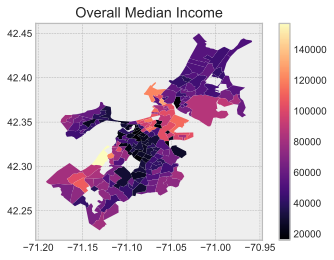

In [6]:
gpd_census_merged[~gpd_census_merged.overall_median_inc.isna()].plot("overall_median_inc",cmap="magma",legend=True);
plt.title("Overall Median Income");

A first naive observation we can already make is that wealth is clearly not homogeneously spread through the city as we can see that the port/downtown area concentrates most of the wealth while the periphery of the city seems quite stalled. We can also study the correlation between all median values of the selected variables in order to grasp already how much redundancy is contained in the dataset.

In [7]:
var_un = [x  for x in list(set(gpd_census_merged.columns)-set(census_tracts.columns))]
var_columns = [x  for x in var_un if"median" in x]
var_corr = gpd_census_merged[var_columns].corr()
var_corr = gpd_census_merged[var_corr.dropna(how="any",axis=1).columns].corr()

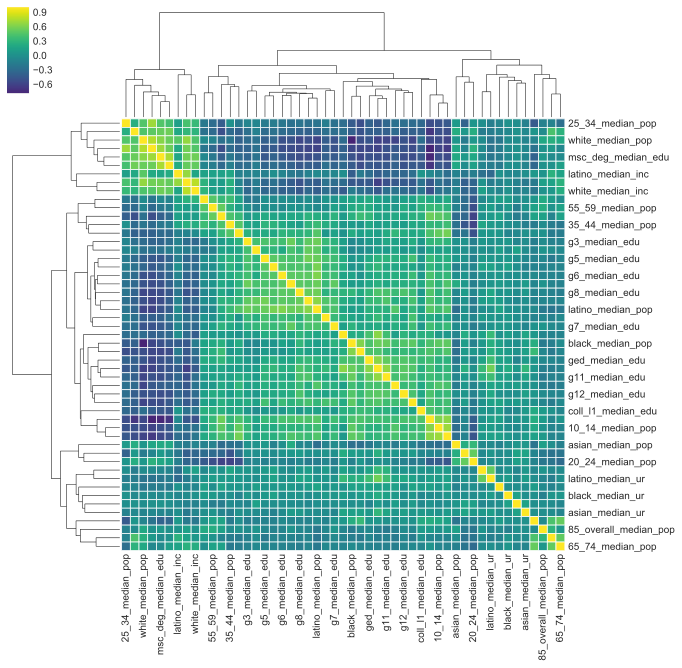

In [8]:
# Draw the full plot
sns.clustermap(var_corr, center=0, cmap="viridis",linewidths=.75);

We see that there are some clear correlations between the selected variables (which was expected) as it's indicated by the overall color of the plot. Nonetheless, they are not so strong as to justify any feature selection step at this point. Perhaps a PCA-based feature reduction step might help generating a more synthetic variable capturing more variance with less data. Now that we've seen the structure of the census data we'll be working with, let's move on to the police information data.

# Police Data

The Police Data we are working with consist of all records of stops performed by the BPD between January, 2011 and June, 2015. In the sea of information that is provided there are some rather relevant variables for our study such as the ethnicity of the stopped citizen, the ID of the officer that conducted the stop as well as his supervisor's as well as the time and place where the stop was performed.

## GeoStatistical Framework

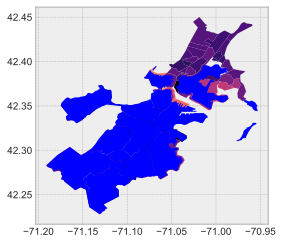

In [10]:
police_districts = gpd.read_file(
    "../data/Dept_11-00091/11-00091_Shapefiles/boston_police_districts_f55.shp").to_crs({'init' :'epsg:4326'})
ax=gpd_census_merged[~gpd_census_merged.overall_median_inc.isna()].plot("overall_median_inc",cmap="magma");
police_districts.plot(ax=ax);

Actually, judging by the above plot (overlay of census tracks polygons and police districts polygon), we see already that the overlap between the census tracks and the police districts is not perfect. This is not a problem _per se_ but it's something to keep in mind. Let's now try obtaining the location of each stop performed by the police.

In [11]:
police_data = pd.read_csv("../data/Dept_11-00091/External_Data/boston-police-department-fio.csv")
street_data = gpd.read_file("../data/Dept_11-00091/External_Data/Boston_Street_Segments.geojson")
street_data = street_data.dissolve(by="STREET_ID").reset_index()[["STREET_ID","geometry"]]

The location is actually provided without any geocoding (the adress in the city is provided rather than the exact coordinates). Two solutions come to mind. The first is to geocode all the 150k recorded stops using something similar to what was provided in Section [4](#Helpers). Even with embarassingly parallel computation, this would take too long so another workaround is actually used: We get all the centroid of every street and assign the stop to that location. This will of course introduce some errors (especially for crimes commited in really long streets such as the ones you may find in the downtown area. The reasoning is hovever that for the most part, this will occur in more secluded spots).

In [12]:
geo_police_data = pd.merge(police_data,street_data,on="STREET_ID")
from shapely.geometry.multilinestring import MultiLineString
new_geom = [Point(k[0].coords) if type(k) is MultiLineString else Point(k.coords) for k in geo_police_data.geometry ]
geo_police_data["geometry"] =  new_geom

In [13]:
geo_police_data.head()

SEQ_NUM  FIO_ID   SEX                       LOCATION DIST  DIST_ID  \
0   938283  621880  MALE       NORMANDY ST at SUPPLE RD   B2        3   
1   886119  569407  MALE       NORMANDY ST at SEAVER ST   B2        3   
2   959173  642093  MALE                 17 NORMANDY ST   B2        3   
3   924604  608155  MALE       NORMANDY ST at SUPPLE RD   B2        3   
4   921989  605536  MALE   NORMANDY ST at CASTLEGATE RD   B2        3   

                 FIO_DATE                FIO_TIME PRIORS  DESCRIPTION  \
0  12/10/2013 12:00:00 AM  12/10/2013 12:00:00 AM    YES     B(Black)   
1  06/20/2012 12:00:00 AM  06/20/2012 12:00:00 AM    YES     B(Black)   
2  06/04/2014 12:00:00 AM  06/04/2014 12:00:00 AM    YES  H(Hispanic)   
3  08/05/2013 12:00:00 AM  08/05/2013 12:00:00 AM    YES     B(Black)   
4  06/26/2013 12:00:00 AM  06/26/2013 12:00:00 AM    YES     B(Black)   

                      ...                      ETHNICITY  \
0                     ...                            NaN   
1                     ...                            BNH   
2                     ...                             AM   
3                     ...                            NaN   
4                     ...                            BNH   

         FIRST_INSERTTIME ACTIVE_ID RACE_ID    RACE_DESC  \
0  01/30/2014 12:00:00 AM         1       2     B(Black)   
1  07/13/2012 12:00:00 AM         1       2     B(Black)   
2  08/14/2014 12:00:00 AM         1       3  H(Hispanic)   
3  08/08/2013 12:00:00 AM         1       2     B(Black)   
4  07/15/2013 12:00:00 AM         1       2     B(Black)   

       FIO_DATE_CORRECTED AGE_AT_FIO_CORRECTED  STREET_ID             CITY  \
0  12/10/2013 12:00:00 AM                   59       3274  NO DATA ENTERED   
1  06/20/2012 12:00:00 AM                   26       3274  NO DATA ENTERED   
2  06/04/2014 12:00:00 AM                   17       3274  NO DATA ENTERED   
3  08/05/2013 12:00:00 AM                   21       3274  NO DATA ENTERED   
4  06/26/2013 12:00:00 AM                   21       3274  NO DATA ENTERED   

                                      geometry  
0  POINT (-71.1592238856294 42.28997753944795)  
1  POINT (-71.1592238856294 42.28997753944795)  
2  POINT (-71.1592238856294 42.28997753944795)  
3  POINT (-71.1592238856294 42.28997753944795)  
4  POINT (-71.1592238856294 42.28997753944795)  

[5 rows x 45 columns]

## Analysis of Stops: Race, Gender, Sex

We can now see for instance the distrbution of stops around the city. As was assumed previously most of the stops seem to have been done in the periphery of the city (see for instance the area south of [Southie](https://www.google.fr/maps/place/South+Boston,+Boston,+Massachusetts,+EE.+UU./@42.324323,-71.1237821,12z/data=!4m5!3m4!1s0x89e37a923d5221c9:0x9e3fb0ad9472dd41!8m2!3d42.3381437!4d-71.0475773)).

In [14]:
geo_police_data["race"] = [re.findall(r'\((.*?)\)', k)[0].split("or")[0] if "(" in k else k for k in list(geo_police_data.RACE_DESC)]

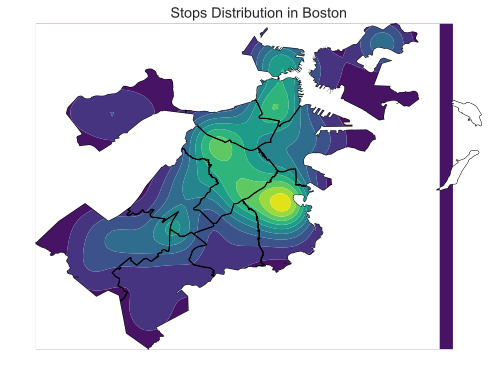

In [15]:
ax = geoplot.kdeplot(geo_police_data.sample(1000),
                     shade=True,legend=False,
                     clip=police_districts.geometry,cmap="viridis");
geoplot.polyplot(police_districts, ax=ax,lw=1,);
ax.set_title("Stops Distribution in Boston");

Let's now study how many stops were performed to Boston residents according to their race, gender and age. 

### Univariate stop distribution

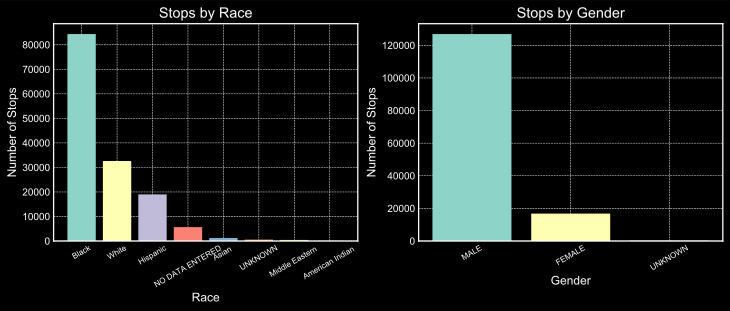

In [16]:
race_stop = geo_police_data['race'].value_counts()
race_keys_to_plot = list(race_stop.keys())
race_vals_to_plot = race_stop.values

gender_stop = geo_police_data['SEX'].value_counts()
gender_keys_to_plot = list(gender_stop.keys())
gender_vals_to_plot = gender_stop.values

with plt.style.context('dark_background'):
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    dim = len(race_vals_to_plot)
    x = np.arange(len(race_vals_to_plot))
    for i,dur in enumerate(race_vals_to_plot):
        b = axes[0].bar(x=i,height=dur, bottom=0.001)
    axes[0].set_xticks(range(len(race_vals_to_plot)))
    axes[0].set_xticklabels(race_keys_to_plot,rotation=30,fontsize=8)
    axes[0].set_xlabel('Race')
    axes[0].set_ylabel('Number of Stops')
    axes[0].set_title("Stops by Race")
    #
    dim = len(gender_vals_to_plot)
    x = np.arange(len(gender_vals_to_plot))
    for i,dur in enumerate(gender_vals_to_plot):
        b = axes[1].bar(x=i,height=dur, bottom=0.001)
    axes[1].set_xticks(range(len(gender_vals_to_plot)))
    axes[1].set_xticklabels(gender_keys_to_plot,rotation=30,fontsize=8)
    axes[1].set_xlabel('Gender')
    axes[1].set_ylabel('Number of Stops')
    axes[1].set_title("Stops by Gender")


So far, the data seems to show that BPD officers stopped in greater number African-American Males. Whites and hispanic follow however the comparison is far from possible. Let's now observe how the count of stops evolves with gender and race.

### Age distribution of stopped according to gender and race

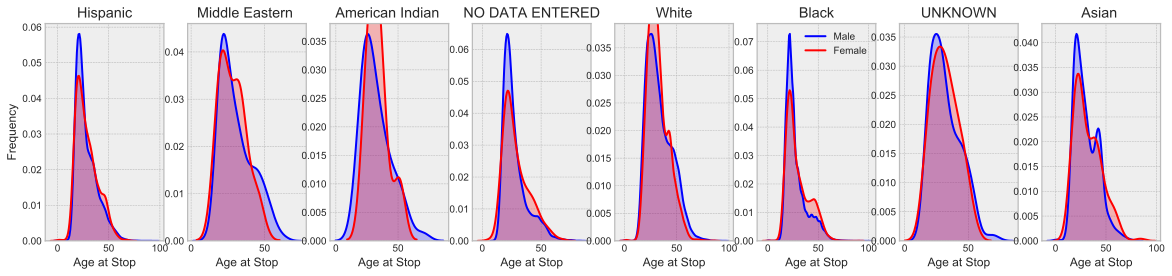

In [17]:
races = list(set(geo_police_data.race))
fig,axes = plt.subplots(1,len(races),figsize=(20,4))
col = ["blue","red"]
for i,race in enumerate(races):
    for j,sex in enumerate(["MALE","FEMALE"]):
        cond = (geo_police_data.SEX==sex) & (geo_police_data.race==race)
        if np.sum(cond)>0:
            age_of_stopped = geo_police_data[cond].AGE_AT_FIO_CORRECTED
            sns.kdeplot(age_of_stopped[(age_of_stopped>0)&(age_of_stopped<100)],shade=True,color=col[j],
                        ax=axes[i]);
        axes[i].set_xlabel("Age at Stop");
        axes[i].set_title(race)
        axes[i].legend([]);


axes[5].legend(["Male","Female"]);
axes[0].set_ylabel("Frequency");

By studying the aforementioned pattern two trends seem to emerge consistently across different ethnicities. First, males seem to be most likely to be stopped when they are in the 20s with a less pronounced peak in their mid 40s for Asian, White and Middle Eastern man. Second, perhaps surprisingly, the same distribution seems to be rather bimodal (with peaks in their 30s and 40s) as well as a bit more shifted to greater ages than for men. A later analysis of the reason behind the stop might help clearify these trends.

### Probability of stopped resident to have a record

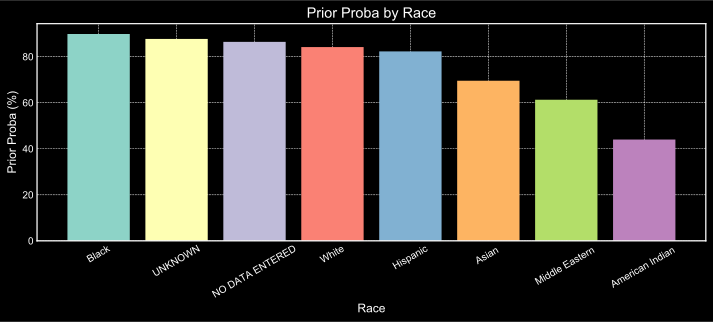

In [18]:
race_prior = []
for race in list(set(geo_police_data.race)):
    dic_priors = geo_police_data[geo_police_data.race==race].groupby("PRIORS")["PRIORS"].count()
    race_prior.append((race,100*dic_priors["YES"]/(dic_priors["YES"]+dic_priors["NO"])))

race_prior_df = pd.DataFrame(race_prior,columns=["race","prior_proba"])
race_prior_df.sort_values("prior_proba",ascending=False,inplace=True)

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(12,4))
    race_keys_to_plot = list(race_prior_df.race)
    race_vals_to_plot = list(race_prior_df.prior_proba)
    dim = len(race_vals_to_plot)
    x = np.arange(len(race_vals_to_plot))
    for i,dur in enumerate(race_vals_to_plot):
        b = ax.bar(x=i,height=dur, bottom=0.001)
    ax.set_xticks(range(len(race_vals_to_plot)))
    ax.set_xticklabels(race_keys_to_plot,rotation=30,fontsize=10)
    ax.set_xlabel('Race')
    ax.set_ylabel('Prior Proba (%)')
    ax.set_title("Prior Proba by Race")



We can also study how sensitive the stop SOP (Standard Operating Procedure) is with respect to non 1st offender (i.e residents with a judicial dossier). It is interesting to see that despite the disparities previously observed in the count data, the sensitivity is actually quite high since for instance 89% of all African-American individuals seems to have some prior. It seems to be less sensitive however with respect to some other minorities such as Middle Easterners and American Indians. This is of course no proof that the system isn't biased because we can't account for any previous biasing (i.e we don't know how these residents acquired that prior in the past)

### Rate of terrorism related stop by race

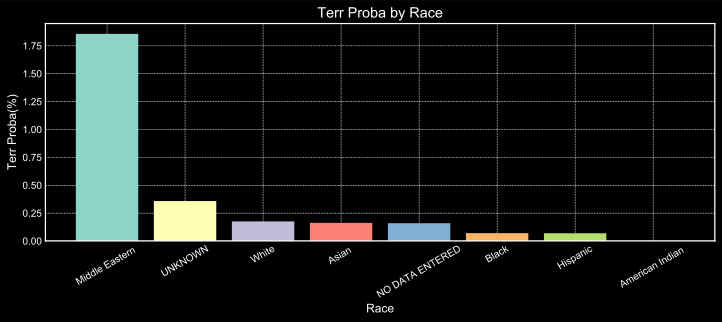

In [19]:
race_terrorism = []
for race in list(set(geo_police_data.race)):
    dic_terr = geo_police_data[geo_police_data.race==race].groupby("TERRORISM")["TERRORISM"].count()
    if "YES" not in dic_terr:
        dic_terr["YES"] = 0
    if "(" in race:
        race=re.findall(r'\((.*?)\)', race)[0].split("or")[0]
    race_terrorism.append((race,100*dic_terr["YES"]/(dic_terr["YES"]+dic_terr["NO"])))

race_terrorism_df = pd.DataFrame(race_terrorism,columns=["race","terr_proba"])
race_terrorism_df.sort_values("terr_proba",ascending=False,inplace=True)

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(12,4))
    race_keys_to_plot = list(race_terrorism_df.race)
    race_vals_to_plot = list(race_terrorism_df.terr_proba)
    dim = len(race_vals_to_plot)
    x = np.arange(len(race_vals_to_plot))
    for i,dur in enumerate(race_vals_to_plot):
        b = ax.bar(x=i,height=dur, bottom=0.001)
    ax.set_xticks(range(len(race_vals_to_plot)))
    ax.set_xticklabels(race_keys_to_plot,rotation=30,fontsize=10)
    ax.set_xlabel('Race')
    ax.set_ylabel('Terr Proba(%)')
    ax.set_title("Terr Proba by Race")



In [29]:
1.75/0.3

5.833333333333334

One clear trend however that is a first and perhaps too familiar evidence of bias by law enforcement is the skew presented above. Namely,  officers tend to stop 580% more often middle easterners on the basis of suspicion of terrorist activities than any other race. 

### Basis for Stop and Actions Taken by Race

In [20]:
# Dummy the variables encoding the actions taken by the officer during the stop 
geo_police_data["observed"] = ["O" in k for k in geo_police_data.FIOFS_TYPE]
geo_police_data["interrogated"] = ["I" in k for k in geo_police_data.FIOFS_TYPE]
geo_police_data["frisked"] = ["F" in k for k in geo_police_data.FIOFS_TYPE]
geo_police_data["searched"] = ["S" in k for k in geo_police_data.FIOFS_TYPE]

In [21]:
geo_police_data.pivot_table(values=["observed","interrogated","frisked","searched"],index=["BASIS","RACE_DESC"],aggfunc=np.mean)

frisked  \
BASIS                RACE_DESC                                        
CONSENT SEARCH       A(Asian or Pacific Islander)          0.370370   
                     B(Black)                              0.581861   
                     H(Hispanic)                           0.477528   
                     M(Middle Eastern or East Indian)      0.400000   
                     NO DATA ENTERED                       0.681818   
                     UNKNOWN                               0.666667   
                     W(White)                              0.448441   
PROBABLE CAUSE       A(Asian or Pacific Islander)          0.500000   
                     B(Black)                              0.634659   
                     H(Hispanic)                           0.572855   
                     I(American Indian or Alaskan Native)  0.100000   
                     M(Middle Eastern or East Indian)      0.391892   
                     NO DATA ENTERED                       0.589041   
                     UNKNOWN                               0.413793   
                     W(White)                              0.447304   
REASONABLE SUSPICION A(Asian or Pacific Islander)          0.444444   
                     B(Black)                              0.479599   
                     H(Hispanic)                           0.382072   
                     I(American Indian or Alaskan Native)  0.000000   
                     M(Middle Eastern or East Indian)      0.178571   
                     NO DATA ENTERED                       0.436364   
                     UNKNOWN                               0.275862   
                     W(White)                              0.231055   

                                                           interrogated  \
BASIS                RACE_DESC                                            
CONSENT SEARCH       A(Asian or Pacific Islander)              0.814815   
                     B(Black)                                  0.789164   
                     H(Hispanic)                               0.629213   
                     M(Middle Eastern or East Indian)          0.800000   
                     NO DATA ENTERED                           0.636364   
                     UNKNOWN                                   0.333333   
                     W(White)                                  0.736211   
PROBABLE CAUSE       A(Asian or Pacific Islander)              0.685000   
                     B(Black)                                  0.742892   
                     H(Hispanic)                               0.701923   
                     I(American Indian or Alaskan Native)      0.600000   
                     M(Middle Eastern or East Indian)          0.635135   
                     NO DATA ENTERED                           0.734589   
                     UNKNOWN                                   0.655172   
                     W(White)                                  0.678903   
REASONABLE SUSPICION A(Asian or Pacific Islander)              0.518519   
                     B(Black)                                  0.642975   
                     H(Hispanic)                               0.586777   
                     I(American Indian or Alaskan Native)      0.200000   
                     M(Middle Eastern or East Indian)          0.392857   
                     NO DATA ENTERED                           0.600000   
                     UNKNOWN                                   0.459770   
                     W(White)                                  0.593652   

                                                           observed  searched  
BASIS                RACE_DESC                                                 
CONSENT SEARCH       A(Asian or Pacific Islander)          0.925926  0.296296  
                     B(Black)                              0.889282  0.329800  
                     H(Hispanic)                           0.865169  0.337079  
        

Although, further insights can be obtained from this matrix, we can already see that African Americans tend to be submitted to further actions by officers when stopped than other reasons 

# Bias Detection: Combination of Police and Census Data

In [22]:
census_data_inter = gpd.GeoDataFrame(gpd_census_merged[var_un+["GEOID","geometry"]])
census_data_inter.crs = {"init":"epsg:4326"}

var_to_agg_dumm = ["observed","interrogated","frisked","searched",
                   "geometry","PRIORS","TERRORISM","AGE_AT_FIO_CORRECTED"]
inter_pol=gpd.GeoDataFrame(pd.concat([geo_police_data[var_to_agg_dumm],
                                      pd.get_dummies(data=geo_police_data[["race","SEX"]])],axis=1))
inter_pol.crs = {"init":"epsg:4326"}

geo_police_data_census = gpd.sjoin(inter_pol,census_data_inter)

## Race Bias in Stops by  Ethnicity 

In [23]:
data_agg_per_census_med = geo_police_data_census.groupby("GEOID").mean()
data_agg_per_census_med_frisk = geo_police_data_census[geo_police_data_census.frisked].groupby("GEOID").mean()
data_agg_per_census_ct = geo_police_data_census.groupby("GEOID")["GEOID"].count()

/Users/jacobolevyabitbol/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:630: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


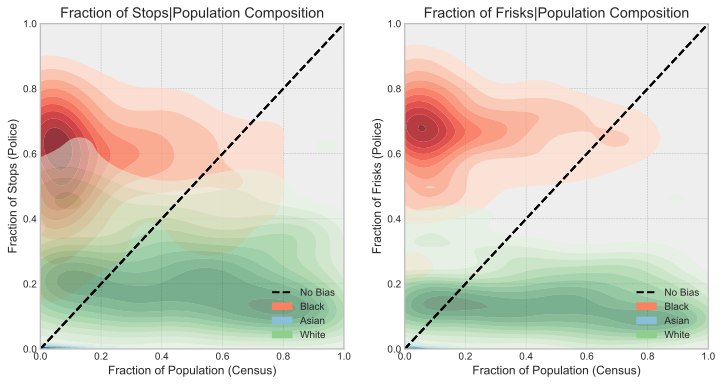

In [24]:
census_cols = ["black_median_pop","asian_median_pop",
              "white_median_pop","hawaiian_median_pop","others_median_pop","latino_median_pop",]
census_cols_to_check = census_cols[:3]
police_cols = ["race_Black","race_Asian ","race_White",
               "race_Middle Eastern ","race_American Indian ","race_Hispanic",
               "race_UNKNOWN","race_NO DATA ENTERED",]
police_cols_to_check = police_cols[:3]
colors = ["Reds","Blues","Greens",]

fig,axes=plt.subplots(1,2,figsize=(12,6))
i,j=0,0
for cens_d,pol_d,col_d in zip(census_cols_to_check,police_cols_to_check,colors):
    axes[j].plot([0,1],[0,1],'--',color='k',label="No Bias");
    census_data = data_agg_per_census_med[cens_d]/data_agg_per_census_med[census_cols].sum(axis=1)
    bias_data = pd.DataFrame([census_data,data_agg_per_census_med[pol_d]]).T.dropna(how="any")
    bias_data.columns = ["census_data","police_data"]
    sns.kdeplot(bias_data,shade=True,shade_lowest=False,clip=[0,1],
                   alpha=[.8,1,.5][i], ax=axes[j],cmap=col_d);
    i+=1;

i=0
j+=1
for cens_d,pol_d,col_d in zip(census_cols_to_check,police_cols_to_check,colors):
    axes[j].plot([0,1],[0,1],'--',color='k',label="No Bias");
    census_data = data_agg_per_census_med_frisk[cens_d]/data_agg_per_census_med_frisk[census_cols].sum(axis=1)
    bias_data = pd.DataFrame([census_data,data_agg_per_census_med_frisk[pol_d]]).T.dropna(how="any")
    bias_data.columns = ["census_data","police_data"]
    sns.kdeplot(bias_data,shade=True,shade_lowest=False,clip=[0,1],
                   alpha=[.8,1,.5][i], ax=axes[j],cmap=col_d);
    i+=1;

r = sns.color_palette("Reds")[2]
b = sns.color_palette("Blues")[2]
g = sns.color_palette("Greens")[2]

nobias = mlines.Line2D([0],[0],linestyle="--",color="k",label="No Bias")
red_patch = mpatches.Patch(color=r, label='Black')
blue_patch = mpatches.Patch(color=b, label='Asian')
green_patch = mpatches.Patch(color=g, label='White')

axes[0].legend(handles=[nobias,red_patch,blue_patch,green_patch],loc="lower right", )
axes[0].set_xlabel("Fraction of Population (Census)");
axes[0].set_ylabel("Fraction of Stops (Police)");
axes[0].set_title("Fraction of Stops|Population Composition");

axes[1].legend(handles=[nobias,red_patch,blue_patch,green_patch],loc="lower right", )
axes[1].set_xlabel("Fraction of Population (Census)");
axes[1].set_ylabel("Fraction of Frisks (Police)");
axes[1].set_title("Fraction of Frisks|Population Composition");

## Race Bias in Stops by  Ethnicity with above average median income 

In [25]:
med_inc = np.nanmean(census_data_inter.overall_median_inc)
afr_not_poor = (geo_police_data_census.white_median_inc>med_inc)&(geo_police_data_census.black_median_inc>med_inc)
data_agg_per_census_med_not_poor = geo_police_data_census[afr_not_poor].groupby("GEOID").mean()
data_agg_per_census_med_frisk_not_poor = geo_police_data_census[afr_not_poor&(geo_police_data_census.frisked)].groupby("GEOID").mean()

/Users/jacobolevyabitbol/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:630: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


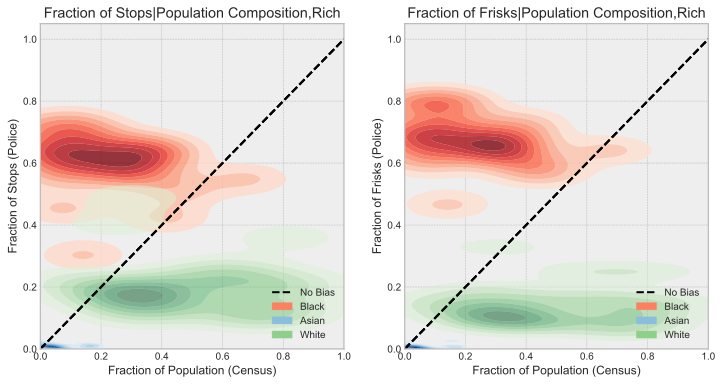

In [26]:
census_cols = ["black_median_pop","asian_median_pop",
              "white_median_pop","hawaiian_median_pop","others_median_pop","latino_median_pop",]
census_cols_to_check = census_cols[:3]
police_cols = ["race_Black","race_Asian ","race_White",
               "race_Middle Eastern ","race_American Indian ","race_Hispanic",
               "race_UNKNOWN","race_NO DATA ENTERED",]
police_cols_to_check = police_cols[:3]
colors = ["Reds","Blues","Greens",]

fig,axes=plt.subplots(1,2,figsize=(12,6))
i,j=0,0
for cens_d,pol_d,col_d in zip(census_cols_to_check,police_cols_to_check,colors):
    axes[j].plot([0,1],[0,1],'--',color='k',label="No Bias");
    census_data = data_agg_per_census_med_not_poor[cens_d]/data_agg_per_census_med_not_poor[census_cols].sum(axis=1)
    bias_data = pd.DataFrame([census_data,data_agg_per_census_med_not_poor[pol_d]]).T.dropna(how="any")
    bias_data.columns = ["census_data","police_data"]
    sns.kdeplot(bias_data,shade=True,shade_lowest=False,clip=[0,1],
                   alpha=[.8,1,.5][i], ax=axes[j],cmap=col_d);
    i+=1;

i=0
j+=1
for cens_d,pol_d,col_d in zip(census_cols_to_check,police_cols_to_check,colors):
    axes[j].plot([0,1],[0,1],'--',color='k',label="No Bias");
    census_data = data_agg_per_census_med_frisk_not_poor[cens_d]/data_agg_per_census_med_frisk_not_poor[census_cols].sum(axis=1)
    bias_data = pd.DataFrame([census_data,data_agg_per_census_med_frisk_not_poor[pol_d]]).T.dropna(how="any")
    bias_data.columns = ["census_data","police_data"]
    sns.kdeplot(bias_data,shade=True,shade_lowest=False,clip=[0,1],
                   alpha=[.8,1,.5][i], ax=axes[j],cmap=col_d);
    i+=1;

r = sns.color_palette("Reds")[2]
b = sns.color_palette("Blues")[2]
g = sns.color_palette("Greens")[2]

nobias = mlines.Line2D([0],[0],linestyle="--",color="k",label="No Bias")
red_patch = mpatches.Patch(color=r, label='Black')
blue_patch = mpatches.Patch(color=b, label='Asian')
green_patch = mpatches.Patch(color=g, label='White')

axes[0].legend(handles=[nobias,red_patch,blue_patch,green_patch],loc="lower right", )
axes[0].set_xlabel("Fraction of Population (Census)");
axes[0].set_ylabel("Fraction of Stops (Police)");
axes[0].set_title("Fraction of Stops|Population Composition,Rich");

axes[1].legend(handles=[nobias,red_patch,blue_patch,green_patch],loc="lower right", )
axes[1].set_xlabel("Fraction of Population (Census)");
axes[1].set_ylabel("Fraction of Frisks (Police)");
axes[1].set_title("Fraction of Frisks|Population Composition,Rich");

## Race Bias in Stops by Ethnicity with below average median unemployment rate 

In [27]:
med_ur = np.nanmean(census_data_inter.overall_median_ur)
afr_not_ur = (geo_police_data_census.white_median_ur<med_ur)&(geo_police_data_census.black_median_ur<med_ur)
data_agg_per_census_med_not_ur = geo_police_data_census[afr_not_ur].groupby("GEOID").mean()
data_agg_per_census_med_frisk_not_ur = geo_police_data_census[afr_not_ur&(geo_police_data_census.frisked)].groupby("GEOID").mean()

/Users/jacobolevyabitbol/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:630: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


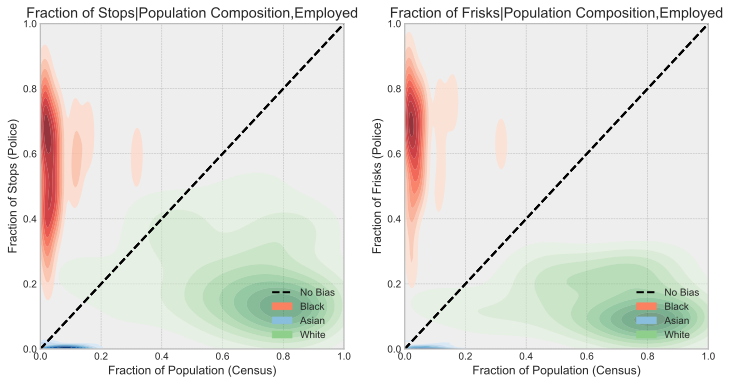

In [28]:
census_cols = ["black_median_pop","asian_median_pop",
              "white_median_pop","hawaiian_median_pop","others_median_pop","latino_median_pop",]
census_cols_to_check = census_cols[:3]
police_cols = ["race_Black","race_Asian ","race_White",
               "race_Middle Eastern ","race_American Indian ","race_Hispanic",
               "race_UNKNOWN","race_NO DATA ENTERED",]
police_cols_to_check = police_cols[:3]
colors = ["Reds","Blues","Greens",]

fig,axes=plt.subplots(1,2,figsize=(12,6))
i,j=0,0
for cens_d,pol_d,col_d in zip(census_cols_to_check,police_cols_to_check,colors):
    axes[j].plot([0,1],[0,1],'--',color='k',label="No Bias");
    census_data = data_agg_per_census_med_not_ur[cens_d]/data_agg_per_census_med_not_ur[census_cols].sum(axis=1)
    bias_data = pd.DataFrame([census_data,data_agg_per_census_med_not_ur[pol_d]]).T.dropna(how="any")
    bias_data.columns = ["census_data","police_data"]
    sns.kdeplot(bias_data,shade=True,shade_lowest=False,clip=[0,1],
                   alpha=[.8,1,.5][i], ax=axes[j],cmap=col_d);
    i+=1;

i=0
j+=1
for cens_d,pol_d,col_d in zip(census_cols_to_check,police_cols_to_check,colors):
    axes[j].plot([0,1],[0,1],'--',color='k',label="No Bias");
    census_data = data_agg_per_census_med_frisk_not_ur[cens_d]/data_agg_per_census_med_frisk_not_ur[census_cols].sum(axis=1)
    bias_data = pd.DataFrame([census_data,data_agg_per_census_med_frisk_not_ur[pol_d]]).T.dropna(how="any")
    bias_data.columns = ["census_data","police_data"]
    sns.kdeplot(bias_data,shade=True,shade_lowest=False,clip=[0,1],
                   alpha=[.8,1,.5][i], ax=axes[j],cmap=col_d);
    i+=1;

r = sns.color_palette("Reds")[2]
b = sns.color_palette("Blues")[2]
g = sns.color_palette("Greens")[2]

nobias = mlines.Line2D([0],[0],linestyle="--",color="k",label="No Bias")
red_patch = mpatches.Patch(color=r, label='Black')
blue_patch = mpatches.Patch(color=b, label='Asian')
green_patch = mpatches.Patch(color=g, label='White')

axes[0].legend(handles=[nobias,red_patch,blue_patch,green_patch],loc="lower right", )
axes[0].set_xlabel("Fraction of Population (Census)");
axes[0].set_ylabel("Fraction of Stops (Police)");
axes[0].set_title("Fraction of Stops|Population Composition,Employed");

axes[1].legend(handles=[nobias,red_patch,blue_patch,green_patch],loc="lower right", )
axes[1].set_xlabel("Fraction of Population (Census)");
axes[1].set_ylabel("Fraction of Frisks (Police)");
axes[1].set_title("Fraction of Frisks|Population Composition,Employed");

# Helpers